# Image Classification: Real vs Fake (AI Generated Synthetic) Image

In [24]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_tuner import HyperModel, Hyperband
from tensorflow.keras.initializers import HeNormal, GlorotUniform

## Load the training and validation dataset

In [2]:
# Load the subset of the CIFAKE dataset
dataset_dir = "/kaggle/input/cifake-real-and-ai-generated-synthetic-images"
print("Loading dataset from: " + dataset_dir)

Loading dataset from: /kaggle/input/cifake-real-and-ai-generated-synthetic-images


In [3]:
# Just to make sure the image size is 32x32
img_height = 32
img_width = 32
batch_size = 32

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir + "/train",
    seed=123,
    validation_split=0.2,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Load the validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir + "/train",
    seed=123,
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width),
    batch_size=batch_size)

# Check if the data is properly loaded
print("Training Classes:")
class_names = train_ds.class_names
print(class_names)

print("Validation Classes:")
class_names = val_ds.class_names
print(class_names)

Found 100000 files belonging to 2 classes.
Using 80000 files for training.
Found 100000 files belonging to 2 classes.
Using 20000 files for validation.
Training Classes:
['FAKE', 'REAL']
Validation Classes:
['FAKE', 'REAL']


## Display some real and synthetic images

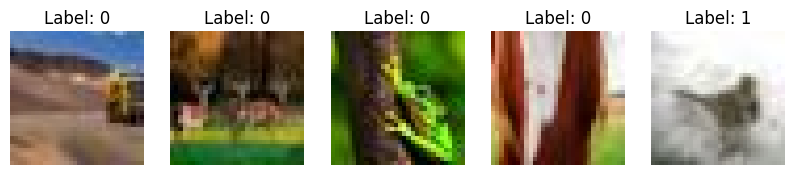

In [4]:
def plot_images_from_dataset(dataset, num_images=5):
    plt.figure(figsize=(10, 10))
    
    for images, labels in dataset.take(1):  # Take one batch from the dataset
        for i in range(num_images):
            plt.subplot(2, num_images, i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"Label: {labels[i].numpy()}")
            plt.axis('off')
    
    plt.show()
    
plot_images_from_dataset(train_ds, num_images=5)

## Define the model and hyperparameter tuner

In [5]:
class MyHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Rescaling(1./255, input_shape=(img_width, img_height, 3)))

        # Tune number of Conv2D layers
        for i in range(hp.Int('conv_layers', 1, 3)):
            filters = hp.Choice(f'filters_{i}', values=[32, 64, 128, 256])
            kernel_size = hp.Choice(f'kernel_size_{i}', values=[3, 5])
            activation = hp.Choice(f'conv_activation_{i}', values=['relu', 'tanh'])
            
            # Choose initializer based on activation
            if activation == 'relu':
                kernel_initializer = HeNormal()
            else:
                kernel_initializer = GlorotUniform()
                
            model.add(Conv2D(filters, kernel_size, padding='same', activation=activation, kernel_initializer=kernel_initializer))
            model.add(MaxPooling2D())

        model.add(Flatten())

        # Tune number of Dense layers
        for i in range(hp.Int('dense_layers', 1, 3)):
            dense_activation = hp.Choice(f'dense_activation_{i}', values=['relu', 'tanh'])
            
            # Choose initializer based on activation
            if dense_activation == 'relu':
                kernel_initializer = HeNormal()
            else:
                kernel_initializer = GlorotUniform()

            model.add(Dense(
                units=hp.Choice(f'units_{i}', values=[64, 128, 256, 1024]),
                activation=dense_activation,
                kernel_initializer=kernel_initializer
            ))
            model.add(Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.1)))

        model.add(Dense(1, activation='sigmoid'))

        # Tune optimizer and learning rate
        optimizer = hp.Choice('optimizer', values=['adam', 'sgd'])
        if optimizer == 'adam':
            optimizer = tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3))
        else:
            optimizer = tf.keras.optimizers.SGD(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3))

        model.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
        )

        return model

In [6]:
tuner = Hyperband(
    MyHyperModel(),
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='/kaggle/working/hyperband_tuning_dir',
    project_name='tuning_convnet')

# Run the Hyperparameter Tuning
tuner.search(train_ds, epochs=20, validation_data=(val_ds))

# Get the Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 08m 44s]
val_accuracy: 0.9378499984741211

Best val_accuracy So Far: 0.9498999714851379
Total elapsed time: 01h 43m 10s


## The best hyperparameters found

In [7]:
print(f"The optimal number of Conv2D layers is {best_hps.get('conv_layers')}")
for i in range(best_hps.get('conv_layers')):
    print(f"Conv2D Layer {i+1}: {best_hps.get(f'filters_{i}')} filters, {best_hps.get(f'kernel_size_{i}')} kernel size, {best_hps.get(f'conv_activation_{i}')} activation")

print(f"The optimal number of Dense layers is {best_hps.get('dense_layers')}")
for i in range(best_hps.get('dense_layers')):
    print(f"Dense Layer {i+1}: {best_hps.get(f'units_{i}')} units, {best_hps.get(f'dense_activation_{i}')} activation")

print(f"The optimal optimizer is {best_hps.get('optimizer')}")
print(f"The optimal learning rate is {best_hps.get('learning_rate')}")

The optimal number of Conv2D layers is 2
Conv2D Layer 1: 256 filters, 3 kernel size, relu activation
Conv2D Layer 2: 32 filters, 3 kernel size, relu activation
The optimal number of Dense layers is 1
Dense Layer 1: 256 units, relu activation
The optimal optimizer is adam
The optimal learning rate is 0.00014751974468970796


## Define early stopping and checkpoints for the model

In [10]:
# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)

# Model checkpoint callback
checkpoint_filepath = '/kaggle/working/best_model.h5'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max')

## Finally, train the model

In [11]:
# Build and train the best model
model = tuner.hypermodel.build(best_hps)

print("Starting training...")
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[early_stopping, model_checkpoint])
print("Training finished.")

Starting training...
Epoch 1/50
2500/2500 [==============================] - 33s 12ms/step - loss: 0.3518 - accuracy: 0.8421 - precision_2: 0.8340 - recall_2: 0.8544 - val_loss: 0.2569 - val_accuracy: 0.8971 - val_precision_2: 0.8659 - val_recall_2: 0.9396
Epoch 2/50
   6/2500 [..............................] - ETA: 25s - loss: 0.3124 - accuracy: 0.8438 - precision_2: 0.8165 - recall_2: 0.8990 

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2500/2500 [==============================] - 25s 10ms/step - loss: 0.2339 - accuracy: 0.9047 - precision_2: 0.8987 - recall_2: 0.9124 - val_loss: 0.2055 - val_accuracy: 0.9201 - val_precision_2: 0.9322 - val_recall_2: 0.9061
Epoch 3/50
2500/2500 [==============================] - 31s 12ms/step - loss: 0.1943 - accuracy: 0.9235 - precision_2: 0.9188 - recall_2: 0.9292 - val_loss: 0.1874 - val_accuracy: 0.9276 - val_precision_2: 0.9550 - val_recall_2: 0.8974
Epoch 4/50
2500/2500 [==============================] - 27s 11ms/step - loss: 0.1703 - accuracy: 0.9326 - precision_2: 0.9304 - recall_2: 0.9352 - val_loss: 0.1594 - val_accuracy: 0.9380 - val_precision_2: 0.9340 - val_recall_2: 0.9426
Epoch 5/50
2500/2500 [==============================] - 33s 13ms/step - loss: 0.1531 - accuracy: 0.9403 - precision_2: 0.9389 - recall_2: 0.9419 - val_loss: 0.1584 - val_accuracy: 0.9394 - val_precision_2: 0.9194 - val_recall_2: 0.9631
Epoch 6/50
2500/2500 [==============================] - 26s 10ms/st

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 256)       7168      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 16, 16, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 32)        73760     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 8, 8, 32)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 2048)             

In [13]:
model.save('/kaggle/working/my_model.keras')

In [14]:
import os
print(os.listdir('/kaggle/working'))

['best_model.h5', '.virtual_documents', 'my_model.keras', 'hyperband_tuning_dir']


## Plot the metrics for evaluation

In [15]:
def plot_metrics(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.savefig('/kaggle/working/accuracy_loss.png')
    plt.show()
    fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot precision
    ax3.plot(history.history['precision_2'], label='Training Precision')
    ax3.plot(history.history['val_precision_2'], label='Validation Precision')
    ax3.set_title('Precision')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Precision')
    ax3.legend()
    
    # Plot recall
    ax4.plot(history.history['recall_2'], label='Training Recall')
    ax4.plot(history.history['val_recall_2'], label='Validation Recall')
    ax4.set_title('Recall')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Recall')
    ax4.legend()
    
    plt.savefig('/kaggle/working/precision_loss.png')
    plt.show()

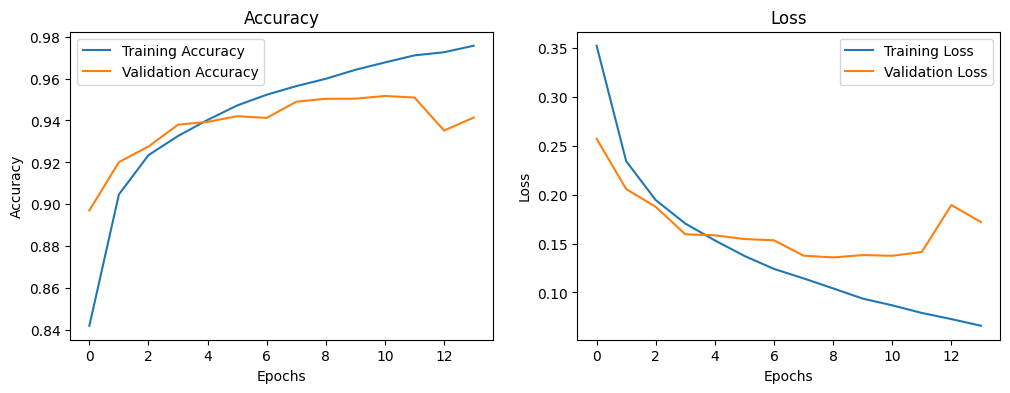

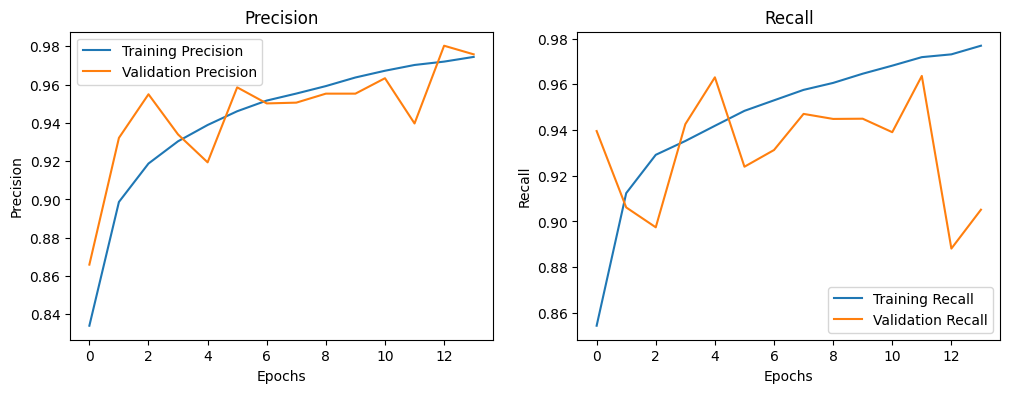

In [16]:
plot_metrics(history)

## Plotting F1 Score

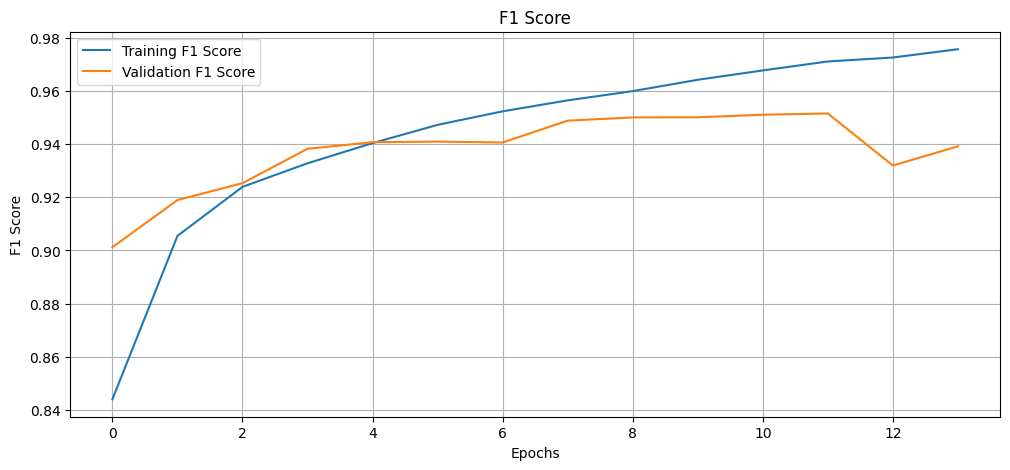

In [17]:
import numpy as np

# Extract precision and recall from the history object
training_precision = history.history['precision_2']
validation_precision = history.history['val_precision_2']
training_recall = history.history['recall_2']
validation_recall = history.history['val_recall_2']

# Function to calculate F1 score
def calculate_f1(precision, recall):
    precision = np.array(precision)
    recall = np.array(recall)
    return 2 * (precision * recall) / (precision + recall)

# Calculate F1 scores
training_f1 = calculate_f1(training_precision, training_recall)
validation_f1 = calculate_f1(validation_precision, validation_recall)

# Plotting F1 Score
epochs = range(len(training_f1))

plt.figure(figsize=(12, 5))
plt.plot(epochs, training_f1, label='Training F1 Score')
plt.plot(epochs, validation_f1, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig('/kaggle/working/f1_score.png')
plt.show()

## Make predictions on the test dataset

In [18]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir + "/test",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 20000 files belonging to 2 classes.


In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")

625/625 [==============================] - 6s 9ms/step - loss: 0.1363 - accuracy: 0.9495 - precision_2: 0.9556 - recall_2: 0.9429
Test Loss: 0.1363
Test Accuracy: 0.9495
Test Precision: 0.9556
Test Recall: 0.9429
